# EMO-DB : Baseline ML pour la détection d'émotion

Ce notebook construit un pipeline ML classique (SVM, RandomForest, XGBoost) pour la classification d'émotions à partir de features extraites des signaux audio.

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import librosa
from pathlib import Path
from tqdm import tqdm
import scipy.stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Chargement des données et extraction des features

In [2]:
# Définition du mapping EMO-DB
EMOTION_MAP = {
    'W': ('anger', 0),
    'L': ('boredom', 1),
    'E': ('disgust', 2),
    'A': ('fear', 3),
    'F': ('happiness', 4),
    'T': ('sadness', 5),
    'N': ('neutral', 6),
}
SAMPLING_RATE = 16000
DATA_DIR = Path('./data')
AUDIO_EXT = '.wav'

In [3]:
def parse_filename(filename):
    m = re.match(r'(\d{2})([a-z]\d{2})([A-Z])([a-z]?)\.wav', filename)
    if not m:
        return None
    speaker, text, emotion_code, version = m.groups()
    emotion, emotion_idx = EMOTION_MAP[emotion_code]
    return {
        'filename': filename,
        'speaker_id': speaker,
        'text_id': text,
        'emotion_code': emotion_code,
        'emotion': emotion,
        'emotion_idx': emotion_idx,
        'version': version or None
    }

In [ ]:
# Split speaker-independant
train_speakers = ['03', '08', '09', '10', '11', '12', '13', '15', '16']
test_speakers = ['14']

In [ ]:
# Extraction des features à partir des fichiers audio
records = []
for fname in tqdm(os.listdir(DATA_DIR), desc='Extraction features'):
    if fname.endswith(AUDIO_EXT):
        meta = parse_filename(fname)
        if meta:
            # Load audio
            fp = str(DATA_DIR / fname)
            y, sr = librosa.load(fp, sr=SAMPLING_RATE)

            # Trim silence
            y_trim, _ = librosa.effects.trim(y, top_db=15)

            # Compute statistical features
            features = {
                'mean': np.mean(y_trim),
                'median': np.median(y_trim),
                'std': np.std(y_trim),
                'min': np.min(y_trim),
                'max': np.max(y_trim),
                'skewness': scipy.stats.skew(y_trim),
                'q25': np.percentile(y_trim, 25),
                'q75': np.percentile(y_trim, 75),
                'kurtosis': scipy.stats.kurtosis(y_trim),
                'duration_sec': len(y)/sr,
                'energy': np.sqrt(np.mean(y_trim**2)),
            }

            # Prosodiques
            f0, voiced_flag, voiced_probs = librosa.pyin(y_trim, fmin=50, fmax=500, sr=sr)
            f0_mean = np.nanmean(f0)
            f0_std = np.nanstd(f0)

            # Taux de passage par zéro
            zcr = np.mean(librosa.feature.zero_crossing_rate(y_trim))

            # Énergie RMS
            rms = np.mean(librosa.feature.rms(y=y_trim))

            # Spectrales
            mfccs = librosa.feature.mfcc(y=y_trim, sr=sr, n_mfcc=13)
            mfccs_mean = np.mean(mfccs, axis=1)
            mfccs_std = np.std(mfccs, axis=1)
            spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y_trim, sr=sr))
            spectral_flux = np.mean(np.diff(librosa.feature.spectral_centroid(y=y_trim, sr=sr)))
            spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y_trim, sr=sr, roll_percent=0.85))

            # Ajout aux features
            features.update(
                {
                    'f0_mean': f0_mean,
                    'f0_std': f0_std,
                    'zcr': zcr,
                    'rms': rms,
                    'spectral_centroid': spectral_centroid,
                    'spectral_flux': spectral_flux,
                    'spectral_rolloff': spectral_rolloff
                }
            )
            for i in range(len(mfccs_mean)):
                features[f'mfcc_{i+1}_mean'] = mfccs_mean[i]
                features[f'mfcc_{i+1}_std'] = mfccs_std[i]

            meta.update(features)
            meta['filepath'] = fp
            # Attribution split
            if meta['speaker_id'] in train_speakers:
                meta['split'] = 'train'
            elif meta['speaker_id'] in test_speakers:
                meta['split'] = 'test'
            else:
                meta['split'] = 'unused'
            records.append(meta)

Extraction features:  28%|██▊       | 150/535 [01:31<03:04,  2.09it/s]C:\Users\perni\AppData\Local\Temp\ipykernel_1324\1480755753.py:31: RuntimeWarning: Mean of empty slice
  f0_mean = np.nanmean(f0)
c:\Users\perni\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Extraction features: 100%|██████████| 535/535 [04:41<00:00,  1.90it/s]


In [32]:
df = pd.DataFrame(records).fillna(0)
df = df[df['split'].isin(['train', 'test'])].copy()

In [33]:
# Features à utiliser
stat_features = ['mean', 'median', 'std', 'min', 'max', 'skewness', 'q25', 'q75', 'kurtosis', 'duration_sec', 'energy']
signal_features = ['f0_mean', 'f0_std', 'zcr', 'rms', 'spectral_centroid', 'spectral_flux', 'spectral_rolloff'] + \
    [f'mfcc_{i+1}_mean' for i in range(13)] + [f'mfcc_{i+1}_std' for i in range(13)]
all_features = stat_features + signal_features

# Encodage de la cible
le = LabelEncoder()
df['emotion_label'] = le.fit_transform(df['emotion'])
print('Classes:', le.classes_)

Classes: ['anger' 'boredom' 'disgust' 'fear' 'happiness' 'neutral' 'sadness']


## 2. Préprocessing et split train/test

In [34]:
# Séparation train/test speaker-independent
X_train = df[df['split']=='train'][all_features].values
y_train = df[df['split']=='train']['emotion_label'].values
X_test = df[df['split']=='test'][all_features].values
y_test = df[df['split']=='test']['emotion_label'].values

# Standardisation
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 3. Grid Search et comparaison des modèles

In [35]:
models = {
    'SVM': (SVC(), {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto'],
        'class_weight': [None, 'balanced'],
    }),
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20],
        #'min_samples_split': [2, 5],
        'class_weight': [None, 'balanced'],
        'min_samples_leaf': [1, 2, 4]
    }),
    'XGBoost': (XGBClassifier(eval_metric='mlogloss', random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.1, 0.3],
        #'subsample': [0.7, 1.0],
        #'colsample_bytree': [0.7, 1.0],
        #'reg_lambda': [0, 0.1, 1.0],
        'reg_alpha': [1.0, 2.0]
    })
}

In [36]:
results = {}
scoring_metric = 'f1_macro'

for name, (model, param_grid) in models.items():
    print(f'\n{name}...')
    clf = GridSearchCV(model, param_grid, cv=3, scoring=scoring_metric)

    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    f1_score_value = f1_score(y_test, y_pred, average='macro')
    balanced_acc = balanced_accuracy_score(y_test, y_pred)

    print(f'Best params: {clf.best_params_}')
    print(f'Accuracy: {acc:.3f}')
    print(f'F1 Score (macro): {f1_score_value:.3f}')
    print(f'Balanced Accuracy: {balanced_acc:.3f}')
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    results[name] = {
        'model': clf,
        'y_pred': y_pred,
        'acc': acc,
        'f1_score': f1_score_value,
        'balanced_acc': balanced_acc
    }


SVM...
Best params: {'C': 1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.739
F1 Score (macro): 0.701
Balanced Accuracy: 0.702
              precision    recall  f1-score   support

       anger       0.75      0.94      0.83        16
     boredom       0.57      1.00      0.73         8
     disgust       0.86      0.75      0.80         8
        fear       0.75      0.75      0.75        12
   happiness       0.40      0.25      0.31         8
     neutral       1.00      0.43      0.60         7
     sadness       1.00      0.80      0.89        10

    accuracy                           0.74        69
   macro avg       0.76      0.70      0.70        69
weighted avg       0.76      0.74      0.73        69


RandomForest...
Best params: {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}
Accuracy: 0.739
F1 Score (macro): 0.690
Balanced Accuracy: 0.694
              precision    recall  f1-score   support

       anger

## 4. Matrices de confusion

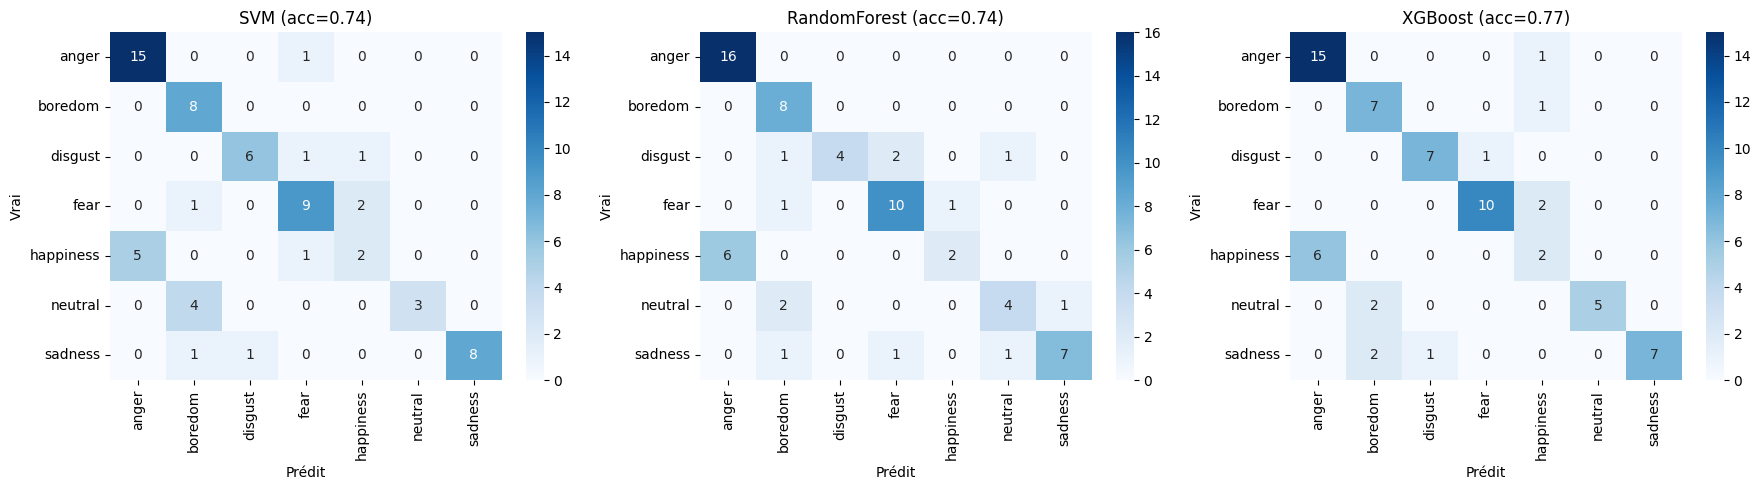

In [37]:
fig, axes = plt.subplots(1, len(results), figsize=(6*len(results), 5))
if len(results) == 1: axes = [axes]
for ax, (name, res) in zip(axes, results.items()):
    cm = confusion_matrix(y_test, res['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, xticklabels=le.classes_, yticklabels=le.classes_)
    ax.set_title(f'{name} (acc={res["acc"]:.2f})')
    ax.set_xlabel('Prédit')
    ax.set_ylabel('Vrai')
plt.tight_layout()
plt.show()

## 5. Analyse des features importantes (RandomForest/XGBoost)

In [42]:
len(all_features)

44

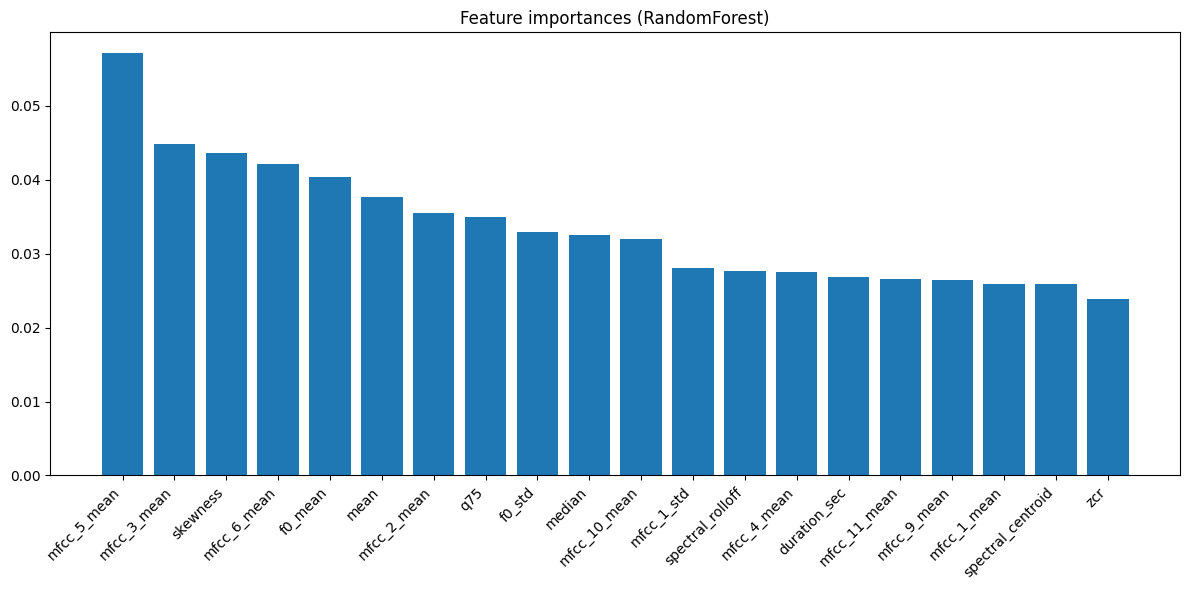

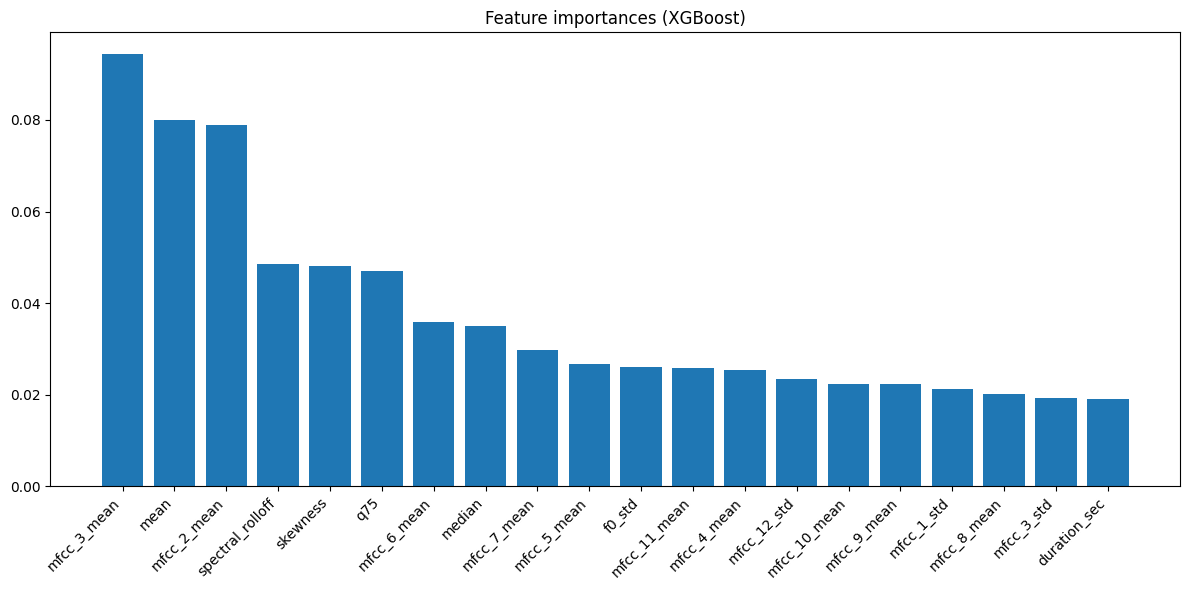

In [50]:
for name in ['RandomForest', 'XGBoost']:
    if name in results:
        clf = results[name]['model'].best_estimator_
        importances = clf.feature_importances_
        idx = np.argsort(importances)[::-1][:20]
        plt.figure(figsize=(12, 6))
        plt.bar(np.array(all_features)[idx], importances[idx])
        plt.title(f'Feature importances ({name})')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()